# **STEP 1:  Data Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Minor Project/input'

/content/drive/MyDrive/Minor Project/input


In [ ]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn
import os as os
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm.notebook as tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, GlobalAveragePooling2D
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology as morph
from skimage import measure

Loading and saving all the directory information

In [ ]:
metadata = pd.read_csv('metadata.csv')
print(metadata.shape)
metadata.head()

(20, 4)


ct_scan  \
0  ../input/covid19-ct-scans/ct_scans/coronacases...   
1  ../input/covid19-ct-scans/ct_scans/coronacases...   
2  ../input/covid19-ct-scans/ct_scans/coronacases...   
3  ../input/covid19-ct-scans/ct_scans/coronacases...   
4  ../input/covid19-ct-scans/ct_scans/coronacases...   

                                           lung_mask  \
0  ../input/covid19-ct-scans/lung_mask/coronacase...   
1  ../input/covid19-ct-scans/lung_mask/coronacase...   
2  ../input/covid19-ct-scans/lung_mask/coronacase...   
3  ../input/covid19-ct-scans/lung_mask/coronacase...   
4  ../input/covid19-ct-scans/lung_mask/coronacase...   

                                      infection_mask  \
0  ../input/covid19-ct-scans/infection_mask/coron...   
1  ../input/covid19-ct-scans/infection_mask/coron...   
2  ../input/covid19-ct-scans/infection_mask/coron...   
3  ../input/covid19-ct-scans/infection_mask/coron...   
4  ../input/covid19-ct-scans/infection_mask/coron...   

                             lung_and_infection_mask  
0  ../input/covid19-ct-scans/lung_and_infection_m...  
1  ../input/covid19-ct-scans/lung_and_infection_m...  
2  ../input/covid19-ct-scans/lung_and_infection_m...  
3  ../input/covid19-ct-scans/lung_and_infection_m...  
4  ../input/covid19-ct-scans/lung_and_infection_m...

# 1. Improving contrast of the images
We will use the createCLAHE fuction from OpenCV to balance out the histogram in a uniform way.Basically, we will try to improve the contrast in such a way that the dark regions are visible and the lighter regions are made clear in a dynamic format.

In [ ]:
img_size = 128
clahe = cv.createCLAHE(clipLimit=7.0) # Set the contrast threshold 3.0
def clahe_enhancer(img, clahe, axes):
  img = np.uint8(img*255)
  clahe_img = clahe.apply(img)
  if len(axes) > 0 :    
    axes[0].imshow(img, cmap='bone')
    axes[0].set_title("Original")
    axes[0].set_xticks([]); axes[0].set_yticks([])
 
    axes[1].imshow(clahe_img, cmap='bone')
    axes[1].set_title("CLAHE")
    axes[1].set_xticks([]); axes[1].set_yticks([])
 
    # Display histograms of CLAHE Enhanced Images vs Original CT Scan images
    if len(axes) > 2 :
      axes[2].hist(img.flatten(), alpha=0.3, color='skyblue', label='Original')
      axes[2].hist(clahe_img.flatten(), alpha=0.3, color='red', label="CLAHE")
      axes[2].legend()
 
  return(clahe_img)

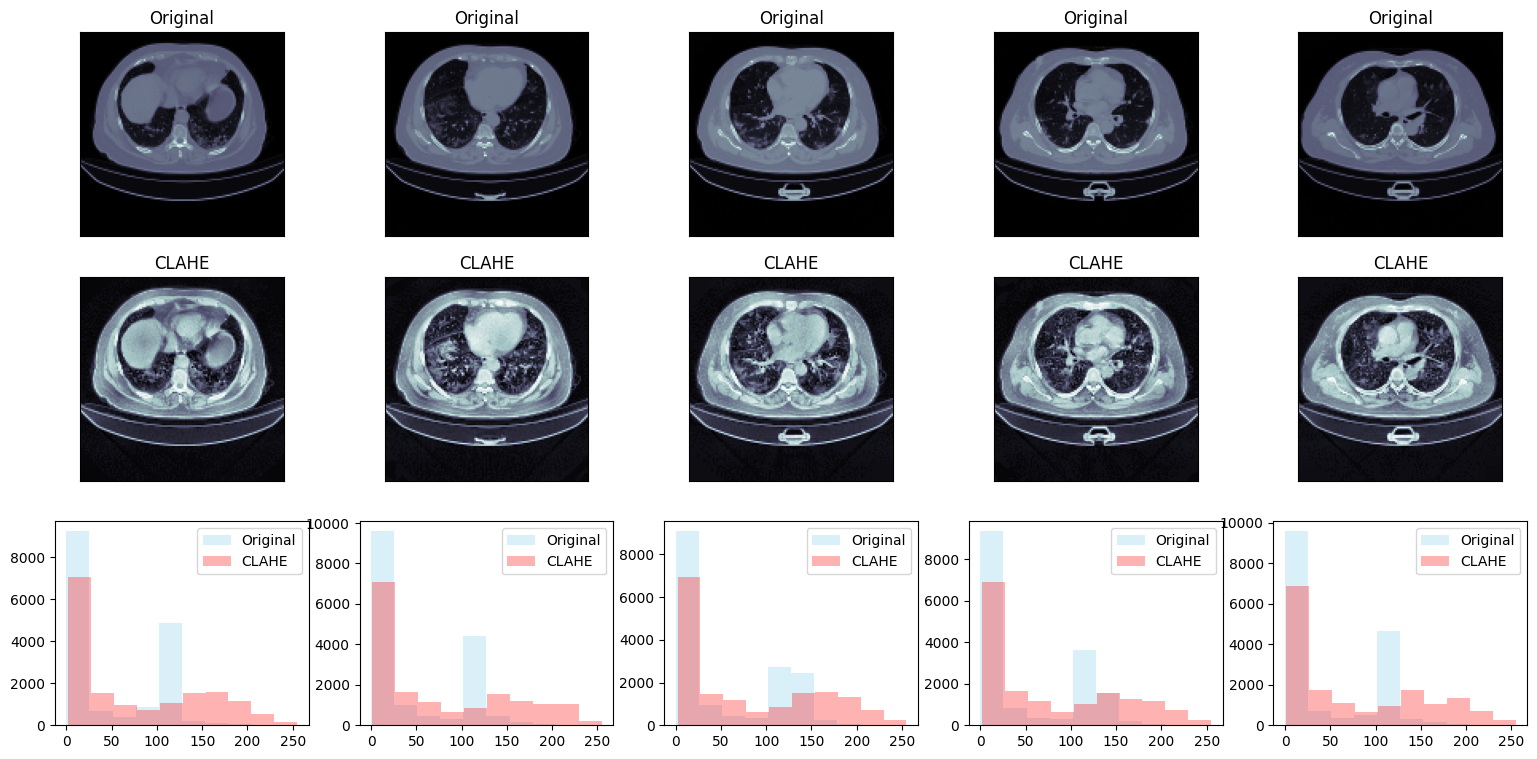

In [ ]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
# print(cts)
a = cts.get_fdata()
a = np.rot90(np.array(a))
a = a[:,:,range(100,200,20)]
# print(a)
a = np.reshape(np.rollaxis(a, 2),(a.shape[2],a.shape[0],a.shape[1], 1))

fig, axes = plt.subplots(3, 5, figsize=(19,9))

for ii in range(a.shape[0]):
    img = cv.resize(a[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA) # Resizing the images into 100 x 100
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii])) # Applying contrast

# 2. Cropping the image
The area of interest for this project is the area where lungs are located. Area other than that is of no use so we will crop out the image and store only the area in which we are interested in.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


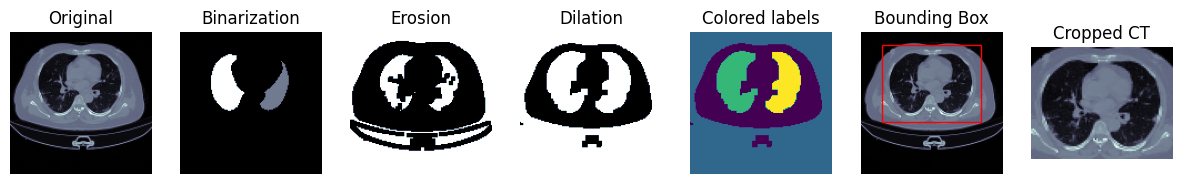

[19, 11, 89, 70]

In [ ]:

def crop_lung(img, boundaries):
  minx, miny, maxx, maxy = boundaries
  return img[miny:miny+maxy, minx:minx+maxx]

def lung_mask_crop(img, mask, dis=False):
  ht, wd = mask.shape
  _, thresh = cv.threshold(mask.astype('uint8'), 0.5, 1, 0)
  contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  img_cnt = cv.drawContours(mask, contours, -1, (0,255,0), 3)
  if len(contours) < 2 :
      raise Exception("Error")
  x0, y0, w0, h0 = cv.boundingRect(contours[0])
  x1, y1, w1, h1 = cv.boundingRect(contours[1])
  B = [min(x0,x1)-round(0.05*wd), min(y0,y1)-round(0.05*ht), max(x0+w0,x1+w1)-min(x0,x1)+round(0.1*wd), 
        max(y0+h0,y1+h1)-min(y0,y1)+round(0.1*ht)]
  B = [max(B[0],0), max(B[1],0), min(B[2], wd), min(B[3], ht)]
  cct_img = crop_lung(img, B)
  rect = patches.Rectangle((B[0],B[1]),B[2],B[3],linewidth=1,edgecolor='r',facecolor='none')

  ht, wd = img.shape
  img = (img-np.mean(img))/np.std(img)
  middle = img[int(wd/5):int(wd/5*4),int(ht/5):int(ht/5*4)] 
  mean = np.mean(middle)  
  imgmax = np.max(img)
  imgmin = np.min(img)
  img[img==imgmax]=mean
  img[img==imgmin]=mean

  # Using KMeans to find clusters or groups of lungs
  kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape),1]))
  centers = sorted(kmeans.cluster_centers_.flatten())
  binary = np.mean(centers)
  binarized = np.where(img<binary,1.0,0.0)

  # Using morphological technique erosion and dilation to perfecty seperate out the individual labels
  eroded = morph.erosion(binarized,np.ones([4,4]))
  dilation = morph.dilation(eroded,np.ones([6,6]))

  labels = measure.label(dilation)
  label_vals = np.unique(labels)
  # print(label_vals)   # Got 4 labels lung1, lung2, CT backgroud, true background 
  regions = measure.regionprops(labels)
  good_labels = []
  try :
    Lung1 = regions[1].bbox
    Lung2 = regions[2].bbox
    bounds = [min(Lung1[0], Lung2[0]), min(Lung1[1], Lung2[1]),
              max(Lung1[2], Lung2[2]), max(Lung1[3], Lung2[3])]
    # print(bounds)
  except :
    bounds = [ht, wd, 0, 0]
  
  if dis:
    fig, ax = plt.subplots(1, 7, figsize=[15, 3])
    ax[0].set_title("Original")
    ax[0].imshow(img, cmap='bone')
    ax[0].axis('off')
    ax[1].set_title("Binarization")
    ax[1].imshow(img_cnt, cmap='bone')
    ax[1].axis('off')
    ax[2].set_title("Erosion")
    ax[2].imshow(eroded, cmap='bone')
    ax[2].axis('off')
    ax[3].set_title("Dilation")
    ax[3].imshow(dilation, cmap='bone')
    ax[3].axis('off')
    ax[4].set_title("Colored labels")
    ax[4].imshow(labels)
    ax[4].axis('off')
    ax[5].set_title("Bounding Box")
    ax[5].imshow(img, cmap='bone')
    ax[5].add_patch(rect)
    ax[5].axis('off')
    ax[6].set_title("Cropped CT")
    ax[6].imshow(crop_lung(img, B), cmap='bone')
    ax[6].axis('off')
    plt.show()

  return B

lung_ = nib.load(metadata.loc[0, 'lung_mask'])
a_lung_ = lung_.get_fdata()
a_lung_ = np.rot90(np.array(a_lung_))
a_lung_ = a_lung_[:,:,range(100,200,10)]
a_lung_ = np.reshape(np.rollaxis(a_lung_, 2),(a_lung_.shape[2],a_lung_.shape[0],a_lung_.shape[1], 1))

img = cv.resize(a[3], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
lmask = cv.resize(a_lung_[3], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
lung_mask_crop(img, lmask, dis=True)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

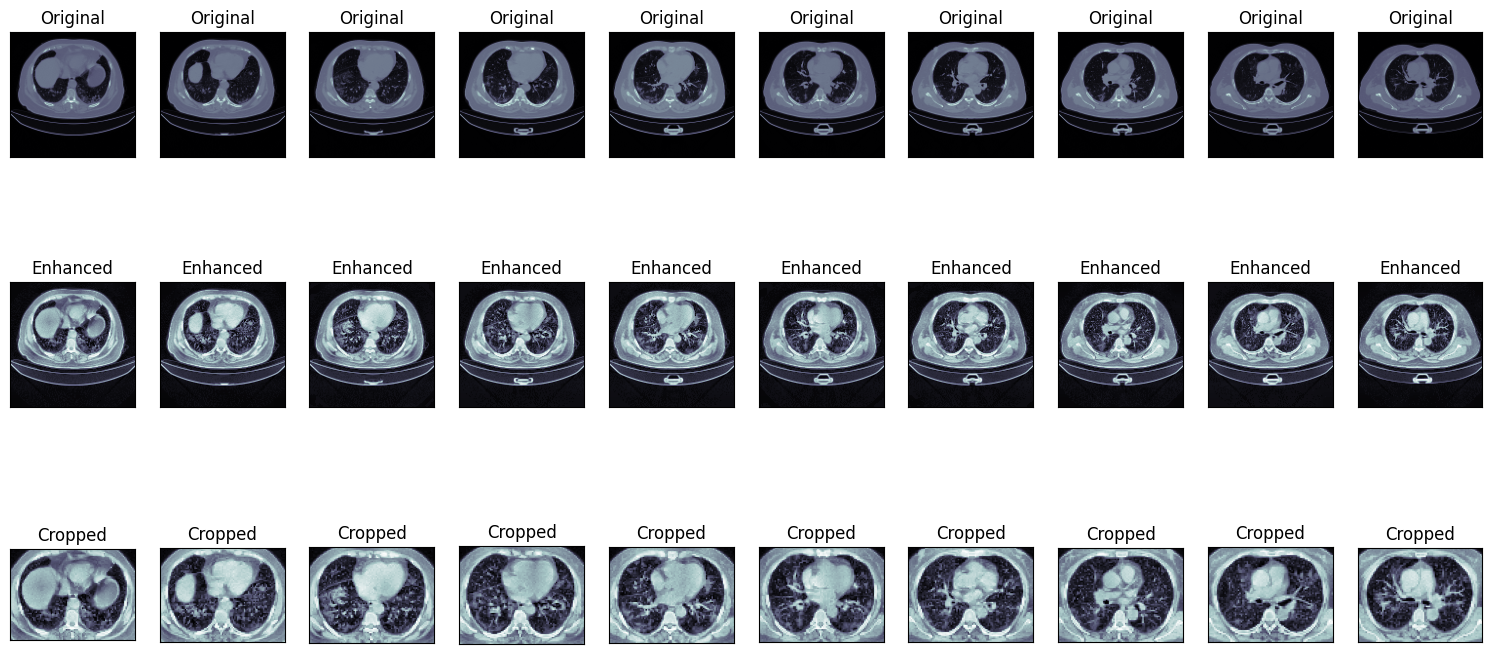

In [ ]:
a = cts.get_fdata()
a = np.rot90(np.array(a))
a = a[:,:,range(100,200,10)]
a = np.reshape(np.rollaxis(a, 2),(a.shape[2],a.shape[0],a.shape[1], 1))

fig, axes = plt.subplots(3, 10, figsize=(19,9))
fig = plt.subplots_adjust(hspace=0.3)

for ii in range(a.shape[0]):
    img = cv.resize(a[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    lmask = cv.resize(a_lung_[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    bounds = lung_mask_crop(img, lmask)
    cropped_img = crop_lung(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

Now we will apply the above techniques on infection and lung mask

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

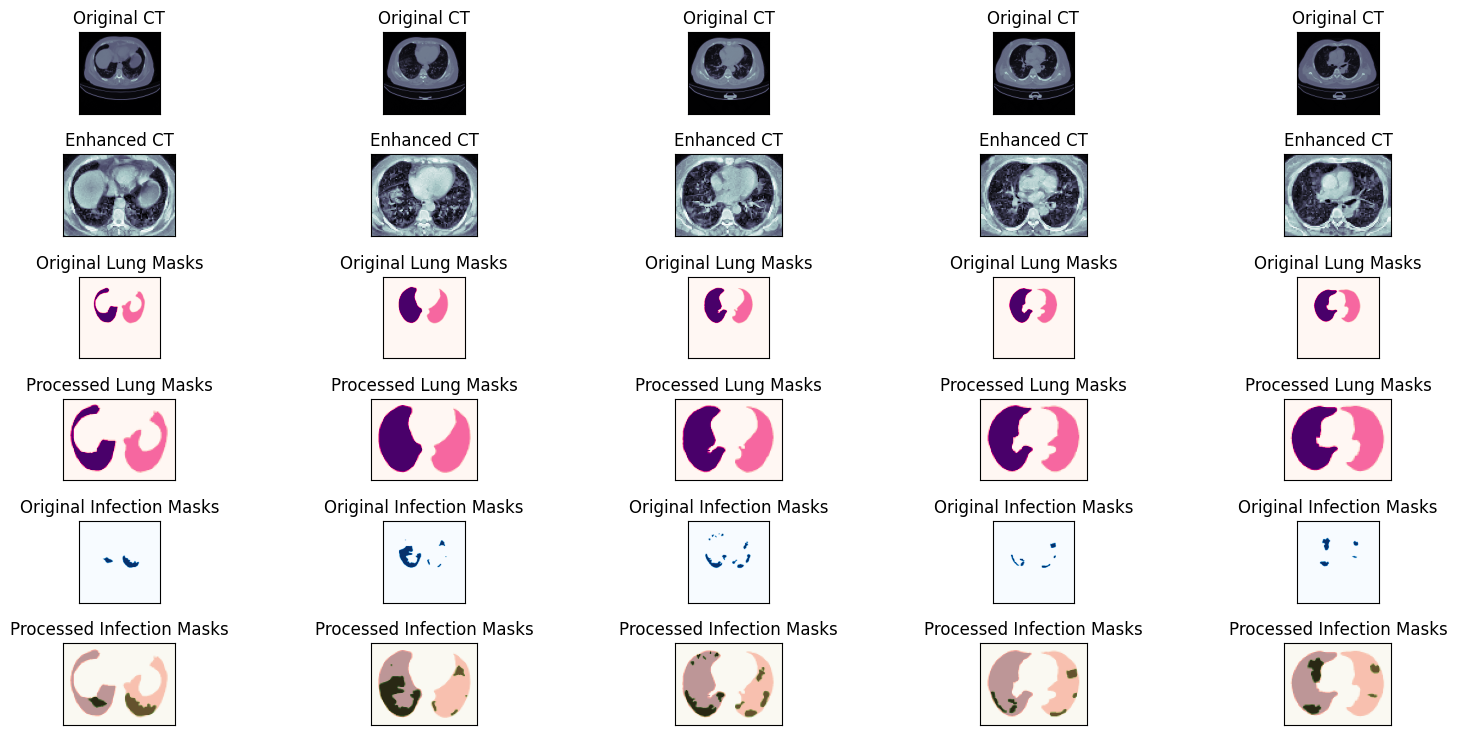

In [ ]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
a_cts = cts.get_fdata()
a_cts = np.rot90(np.array(a_cts))
a_cts = a_cts[:,:,range(100,200,20)]
a_cts = np.reshape(np.rollaxis(a_cts, 2),(a_cts.shape[2],a_cts.shape[0],a_cts.shape[1], 1))

inf = nib.load(metadata.loc[0, 'infection_mask'])
a_inf = inf.get_fdata()
a_inf = np.rot90(np.array(a_inf))
a_inf = a_inf[:,:,range(100,200,20)]
a_inf = np.reshape(np.rollaxis(a_inf, 2),(a_inf.shape[2],a_inf.shape[0],a_inf.shape[1], 1))

lung = nib.load(metadata.loc[0, 'lung_mask'])
a_lung = lung.get_fdata()
a_lung = np.rot90(np.array(a_lung))
a_lung = a_lung[:,:,range(100,200,20)]
a_lung = np.reshape(np.rollaxis(a_lung, 2),(a_lung.shape[2],a_lung.shape[0],a_lung.shape[1], 1))

fig, axes = plt.subplots(6, 5, figsize=(19,9))
fig = plt.subplots_adjust(hspace=0.5)

for i in range (a_cts.shape[0]):
  img_cts = cv.resize(a_cts[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
  img_lung = cv.resize(a_lung[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
  img_lung_o = cv.resize(a_lung[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
  img_inf = cv.resize(a_inf[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

  xmax, xmin = img_cts.max(), img_cts.min()
  img_cts = (img_cts - xmin)/(xmax - xmin)

  bounds = lung_mask_crop(img_cts, img_lung)

  axes[0,i].imshow(img_cts, cmap='bone')
  axes[0,i].set_title('Original CT')
  axes[0,i].set_xticks([]); axes[0,i].set_yticks([])
  
  img_cts = clahe_enhancer(img_cts, clahe, [])
  img_cts = crop_lung(img_cts, bounds)
  axes[1,i].imshow(img_cts, cmap='bone')
  axes[1,i].set_title('Enhanced CT')
  axes[1,i].set_xticks([]); axes[1,i].set_yticks([])

  axes[2,i].imshow(img_lung_o, cmap='RdPu')
  axes[2,i].set_title('Original Lung Masks')
  axes[2,i].set_xticks([]); axes[2,i].set_yticks([])

  img_lung_o = crop_lung(img_lung_o, bounds)
  axes[3,i].imshow(img_lung_o, cmap='RdPu')
  axes[3,i].set_title('Processed Lung Masks')
  axes[3,i].set_xticks([]); axes[3,i].set_yticks([])
  
  axes[4,i].imshow(img_inf, cmap='Blues')
  axes[4,i].set_title('Original Infection Masks')
  axes[4,i].set_xticks([]); axes[4,i].set_yticks([])

  img_inf = crop_lung(img_inf, bounds)
  axes[5,i].imshow(img_lung_o, cmap='Reds')
  axes[5,i].imshow(img_inf, alpha=0.6, cmap='Greens')
  axes[5,i].set_title('Processed Infection Masks')
  axes[5,i].set_xticks([]); axes[5,i].set_yticks([])

# 4. Loading all the data
Now load all the data and convert them into tensors.

In [ ]:
all_cts = []
all_inf = []
all_lungs = []
bad_id = []

for i in tqdm.tqdm(range(20)) :
  cts = nib.load(metadata.loc[i, 'ct_scan'])
  inf = nib.load(metadata.loc[i, 'infection_mask'])
  lung = nib.load(metadata.loc[i, 'lung_mask'])

  a_cts = cts.get_fdata()
  a_inf = inf.get_fdata()
  a_lung = lung.get_fdata()

  slice_range = range(round(a_cts.shape[2]*0.2), round(a_cts.shape[2]*0.8))

  a_cts = np.rot90(np.array(a_cts))
  a_cts = a_cts[:,:,slice_range]
  a_cts = np.reshape(np.rollaxis(a_cts, 2),(a_cts.shape[2],a_cts.shape[0],a_cts.shape[1], 1))
  
  a_inf = np.rot90(np.array(a_inf))
  a_inf = a_inf[:,:,slice_range]
  a_inf = np.reshape(np.rollaxis(a_inf, 2),(a_inf.shape[2],a_inf.shape[0],a_inf.shape[1], 1))

  a_lung = np.rot90(np.array(a_lung))
  a_lung = a_lung[:,:,slice_range]
  a_lung = np.reshape(np.rollaxis(a_lung, 2),(a_lung.shape[2],a_lung.shape[0],a_lung.shape[1], 1))

  print(a_cts.shape)
  print(a_lung.shape)
  print(a_inf.shape)

  for j in range(a_cts.shape[0]):
    try:
      img_cts = cv.resize(a_cts[j], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_lung = cv.resize(a_lung[j], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_lung_o = cv.resize(a_lung[j], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_inf = cv.resize(a_inf[j], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

      xmax, xmin = img_cts.max(), img_cts.min()
      img_cts = (img_cts - xmin)/(xmax - xmin)

      bounds = lung_mask_crop(img_cts, img_lung)

      img_cts = clahe_enhancer(img_cts, clahe, [])
      img_cts = crop_lung(img_cts, bounds)
      all_cts.append(img_cts)

      img_lung_o = crop_lung(img_lung_o, bounds)
      all_lungs.append(img_lung_o)

      img_inf = crop_lung(img_inf, bounds)
      all_inf.append(img_inf)
    except:
      bad_id.append(j)

  0%|          | 0/20 [00:00<?, ?it/s]

(181, 512, 512, 1)
(181, 512, 512, 1)
(181, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(120, 512, 512, 1)
(120, 512, 512, 1)
(120, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(120, 512, 512, 1)
(120, 512, 512, 1)
(120, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(162, 512, 512, 1)
(162, 512, 512, 1)
(162, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(174, 512, 512, 1)
(174, 512, 512, 1)
(174, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(127, 512, 512, 1)
(127, 512, 512, 1)
(127, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(149, 512, 512, 1)
(149, 512, 512, 1)
(149, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(181, 512, 512, 1)
(181, 512, 512, 1)
(181, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(154, 512, 512, 1)
(154, 512, 512, 1)
(154, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(181, 512, 512, 1)
(181, 512, 512, 1)
(181, 512, 512, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(23, 630, 630, 1)
(23, 630, 630, 1)
(23, 630, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(250, 630, 630, 1)
(250, 630, 630, 1)
(250, 630, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(66, 401, 630, 1)
(66, 401, 630, 1)
(66, 401, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(40, 630, 630, 1)
(40, 630, 630, 1)
(40, 630, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(26, 630, 630, 1)
(26, 630, 630, 1)
(26, 630, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(26, 630, 630, 1)
(26, 630, 630, 1)
(26, 630, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(27, 630, 630, 1)
(27, 630, 630, 1)
(27, 630, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(55, 630, 630, 1)
(55, 630, 630, 1)
(55, 630, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(23, 630, 630, 1)
(23, 630, 630, 1)
(23, 630, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

(27, 630, 630, 1)
(27, 630, 630, 1)
(27, 630, 630, 1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [ ]:
print(len(all_cts))
print(len(all_lungs))
print(len(all_inf))

2063
2063
2063


Reshape the nparray to 128 x 128 x 1

In [ ]:
del_lst = []
for i in tqdm.tqdm(range(len(all_cts))) :
  try :
    all_cts[i] = cv.resize(all_cts[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_cts[i] = np.reshape(all_cts[i], (img_size, img_size, 1))
    all_lungs[i] = cv.resize(all_lungs[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_lungs[i] = np.reshape(all_lungs[i], (img_size, img_size, 1))
    all_inf[i] = cv.resize(all_inf[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_inf[i] = np.reshape(all_inf[i], (img_size, img_size, 1))
  except :
    del_lst.append(i)      

for idx in del_lst[::-1] :
  del all_cts[idx]
  del all_lungs[idx]
  del all_inf[idx]

  0%|          | 0/2063 [00:00<?, ?it/s]

In [ ]:
print(len(all_cts))
print(len(all_lungs))
print(len(all_inf))

2063
2063
2063


# 5. Final Visualization

Text(0.5, 1.0, 'Processed Infection Mask')

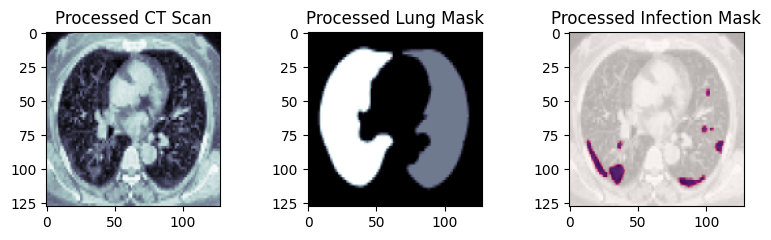

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))
fig = plt.subplots_adjust(wspace=0.5)
axes[0].imshow(all_cts[100][:, :, 0], cmap='bone')
axes[0].set_title("Processed CT Scan")

axes[1].imshow(all_lungs[100][:, :, 0], cmap='bone')
axes[1].set_title("Processed Lung Mask")

axes[2].imshow(all_cts[100][:, :, 0], cmap='gray')
axes[2].imshow(all_inf[100][:, :, 0], alpha=0.7, cmap='RdPu')
axes[2].set_title("Processed Infection Mask")

# 6. Saving all the data 

In [ ]:
with open('Processed_Data_Classification.cp', 'wb') as myfile:
    pickle.dump({'cts': all_cts, 'lungs': all_lungs, 'infects': all_inf}, myfile)

# 7. Deleting blank masks
Deleting the blank infection mask is important so that our model can easily predict the desired infection mask required.

Here we will delete all the blank infection masks along with their corresponding ct scans and lung masks. To approach this we will use np.unique to identify the unique elements and if its size is 1 it means the mask is blank and then store the result in an index_arr list.

Then sort the index_arr list in descending order and using del delete the index on ct scans, lung masks as well as blank infection masks.

Number of CTS with no infection  499
Number of CT slices available after deletion of non-infection masks  1564


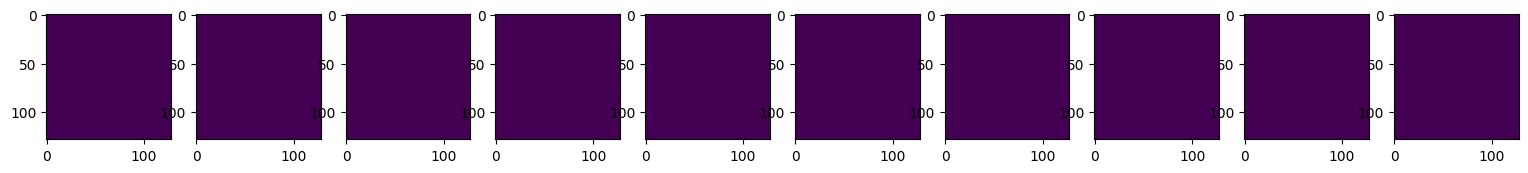

In [ ]:
total_slides = len(all_cts)
index_arr = []
inf_check = np.ones((1, len(all_inf)))
for i in range(len(all_inf)):
  if np.unique(all_inf[i]).size == 1:
    inf_check[0, i] = 0
    index_arr.append(i)

print("Number of CTS with no infection ", len(index_arr))

# Testing the black masks
fig, axes = plt.subplots(1, 10, figsize=(19,9))
tmp = 0
for i in index_arr:
  img_inf = cv.resize(all_inf[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
  axes[tmp].imshow(img_inf)
  tmp += 1
  if tmp==10:
    break

for i in index_arr[::-1]:
  del all_cts[i]
  del all_inf[i]
  del all_lungs[i]

print("Number of CT slices available after deletion of non-infection masks ", len(all_cts))

In [ ]:
all_cts = np.array(all_cts)
all_lungs = np.array(all_lungs)
all_inf = np.array(all_inf)

print(all_cts.shape)
print(all_lungs.shape)
print(all_inf.shape)

(1564, 128, 128, 1)
(1564, 128, 128, 1)
(1564, 128, 128, 1)


# 8. Visualising the final fully processed images

In [ ]:
def plot_cts_infects(ct, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('CT image')

    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='nipy_spectral')
    axes[1].set_title('Infection')

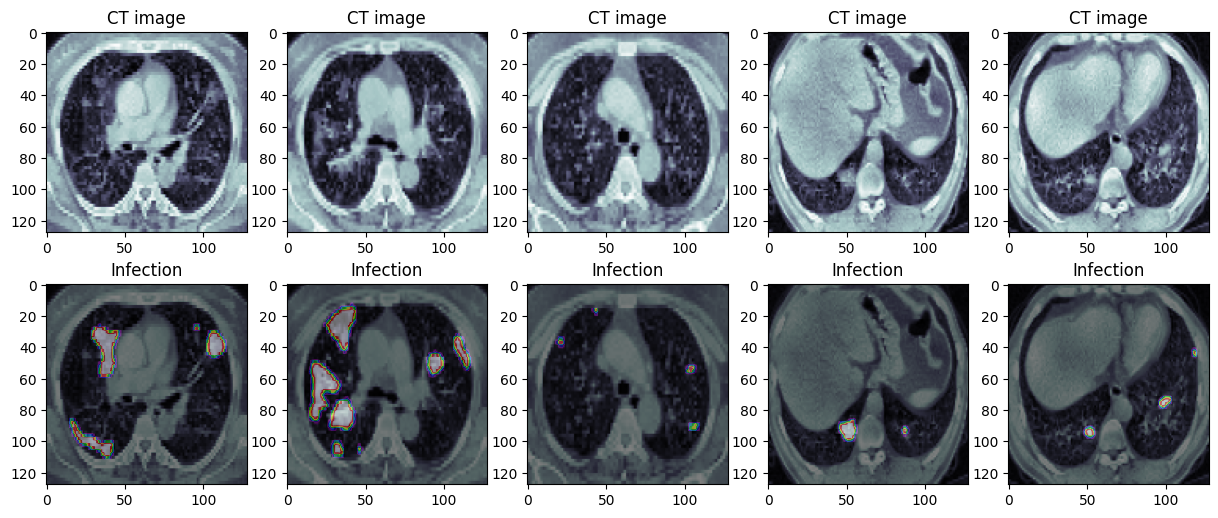

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for ii, idx in enumerate(range(100, 200, 20)) :
    plot_cts_infects(all_cts[idx], all_inf[idx], list(axes[:,ii]))

# 9. Saving Data
Saving these processed images so that this procedure can be avoided in future.

In [ ]:
with open('Processed_Data.cp', 'wb') as myfile:
    pickle.dump({'cts': all_cts, 'lungs': all_lungs, 'infects': all_inf}, myfile)

# **STEP 2: Classification**



# 1. Loading the data

In [ ]:
infile = open('Processed_Data_Classification.cp','rb')
data_dict = pickle.load(infile)
all_cts = data_dict['cts']
all_inf = data_dict['infects']
infile.close()

In [ ]:
from sklearn.utils import shuffle
all_cts, all_inf = shuffle(all_cts, all_inf) #synchronized shuffling of data

In [ ]:
all_cts = np.array(all_cts)
all_inf = np.array(all_inf)

In [ ]:
print(all_cts.shape)
print(all_inf.shape)

(2063, 128, 128, 1)
(2063, 128, 128, 1)


In [ ]:
all_cts = (all_cts - all_cts.min())/(all_cts.max()-all_cts.min())
all_inf = (all_inf - all_inf.min())/(all_inf.max()-all_inf.min())

In [ ]:
print("{} {}".format(all_cts.min(), all_cts.max()))
print("{} {}".format(all_inf.min(), all_inf.max()))

0.0 1.0
0.0 1.0


# 2. Creating labels

Number of CTS with no infection  499


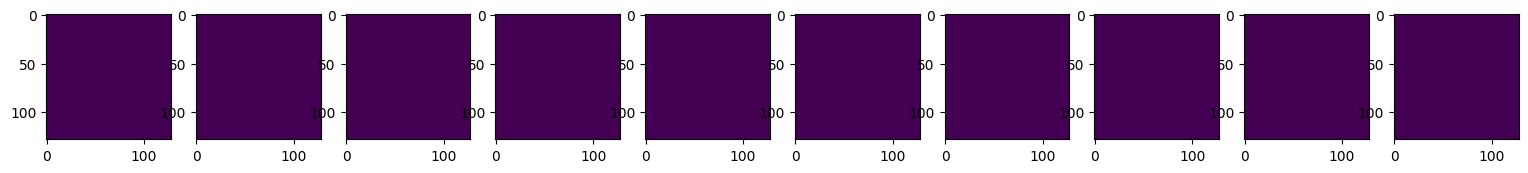

In [ ]:
total_slides = len(all_cts)
index_arr = []
inf_check = np.ones((len(all_inf)))
for i in range(len(all_inf)):
  if np.unique(all_inf[i]).size == 1:
    inf_check[i] = 0
    index_arr.append(i)

print("Number of CTS with no infection ", len(index_arr))

fig, axes = plt.subplots(1, 10, figsize=(19,9))
tmp = 0
for i in index_arr:
  img_inf = cv.resize(all_inf[i], dsize=(128, 128), interpolation=cv.INTER_AREA)
  axes[tmp].imshow(img_inf)
  tmp += 1
  if tmp==10:
    break

# 3. Splitting the data

In [ ]:
X_train = all_cts[:int(len(all_cts)*0.6)]
Y_train = inf_check[:int(len(inf_check)*0.6)]
X_val = all_cts[int(len(all_cts)*0.6):int(len(all_cts)*0.8)]
Y_val = inf_check[int(len(inf_check)*0.6):int(len(inf_check)*0.8)]
X_test = all_cts[int(len(all_cts)*0.8):]
Y_test = inf_check[int(len(inf_check)*0.8):]

In [ ]:
X_test_inf = all_inf[int(len(all_inf)*0.8):]

In [ ]:
print("{} {}".format(X_train.shape, Y_train.shape))
print("{} {}".format(X_val.shape, Y_val.shape))
print("{} {}".format(X_test.shape, Y_test.shape))

(1237, 128, 128, 1) (1237,)
(413, 128, 128, 1) (413,)
(413, 128, 128, 1) (413,)


# 4. Defining the Neural network

In [ ]:
def get_model(width=128, height=128):

    inputs = Input((width, height, 1))

    x = Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.3)(x)

    outputs = Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = Model(inputs, outputs, name="2dcnn")
    return model

In [ ]:
model = get_model(width=128, height=128)
model.summary()

Model: "2dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 63, 63, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0     

# 5. Compiling the model

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)
checkpoint_cb = callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)

# 6. Training

In [ ]:
history = model.fit(X_train, Y_train, epochs = 100, validation_data = (X_val, Y_val), callbacks = [checkpoint_cb],  shuffle=True, verbose=1)

Epoch 1/100
39/39 [==============================] - 14s 82ms/step - loss: 0.5885 - acc: 0.7187 - val_loss: 0.6063 - val_acc: 0.7554
Epoch 2/100
39/39 [==============================] - 1s 36ms/step - loss: 0.4312 - acc: 0.8319 - val_loss: 0.5738 - val_acc: 0.7554
Epoch 3/100
39/39 [==============================] - 1s 31ms/step - loss: 0.3426 - acc: 0.8634 - val_loss: 0.6726 - val_acc: 0.7554
Epoch 4/100
39/39 [==============================] - 1s 31ms/step - loss: 0.2927 - acc: 0.8892 - val_loss: 0.6997 - val_acc: 0.4165
Epoch 5/100
39/39 [==============================] - 2s 39ms/step - loss: 0.2567 - acc: 0.9014 - val_loss: 0.5551 - val_acc: 0.7554
Epoch 6/100
39/39 [==============================] - 1s 30ms/step - loss: 0.2107 - acc: 0.9256 - val_loss: 0.6686 - val_acc: 0.6320
Epoch 7/100
39/39 [==============================] - 1s 30ms/step - loss: 0.1768 - acc: 0.9458 - val_loss: 0.5677 - val_acc: 0.7530
Epoch 8/100
39/39 [==============================] - 1s 33ms/step - loss: 0

# 7. Plotting the accuracy and loss

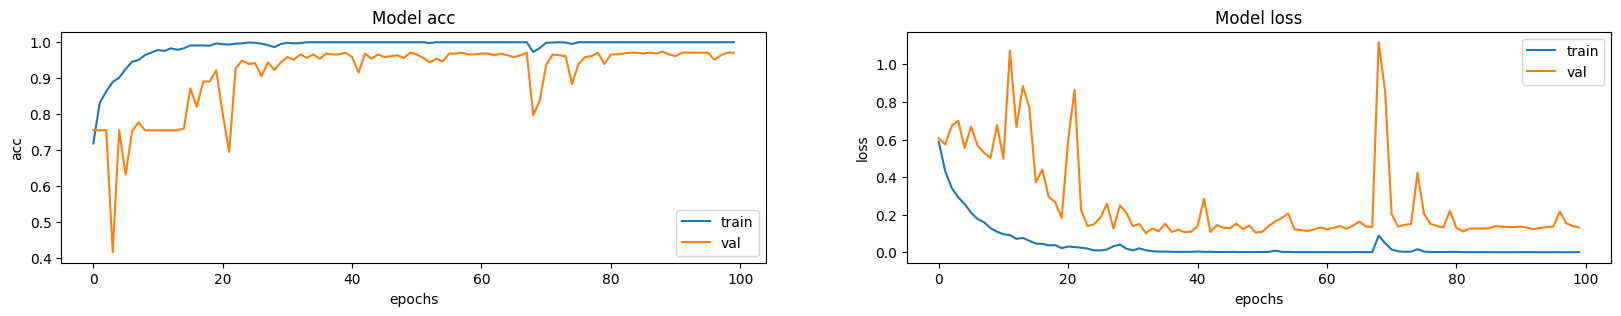

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# 8. Predicting on the test dataset

In [ ]:
model.load_weights("3d_image_classification.h5")
prediction = model.predict(X_test)

13/13 [==============================] - 0s 11ms/step


# 9. Calculating optimal threshold

In [ ]:
from sklearn import metrics as mt
fpr, tpr, thresholds = mt.roc_curve(Y_test,prediction)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
prediction = prediction > optimal_threshold

# 10. Calculating precision, recall and F1 score

Precision: 0.9931740614334471 and Recall: 0.9356913183279743
F1 score: 0.9635761589403973


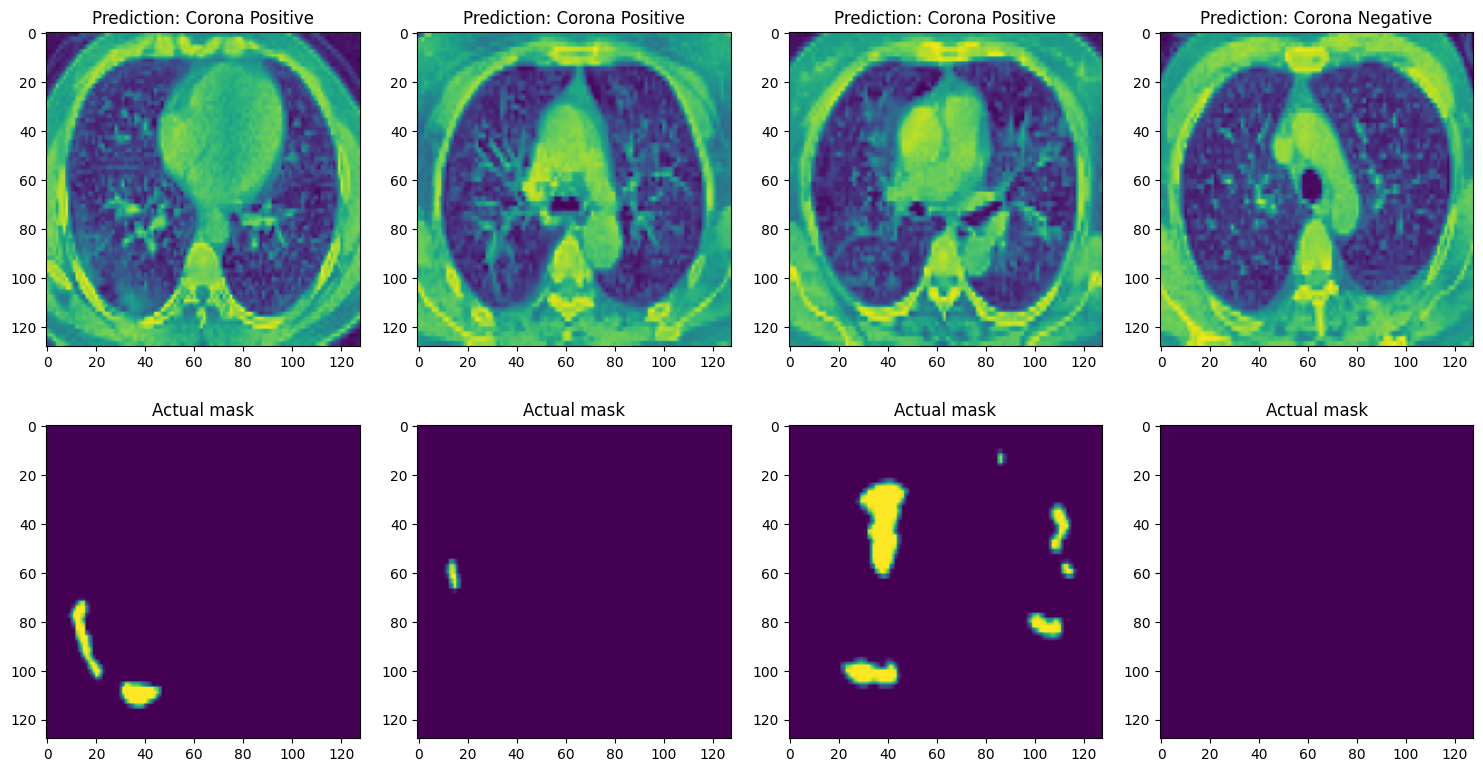

In [ ]:
tn, fp, fn, tp = mt.confusion_matrix(Y_test, prediction).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision: {} and Recall: {}".format(precision, recall))
print("F1 score: {}".format(2*precision*recall/(precision+recall)))
import random
fig, axes = plt.subplots(2, 4, figsize=(15,8))
fig.tight_layout()
for i in range(4):
    c = random.randint(0,prediction.shape[0]-1)
    axes[0,i].imshow(np.squeeze(X_test[c]))
    result = 'res'
    if(prediction[c]): 
      result = 'Positive'
    else: 
      result = 'Negative'
    axes[0,i].set_title('Prediction: Corona {}'.format(result))
    axes[1,i].imshow(np.squeeze(X_test_inf[c]))
    axes[1,i].set_title('Actual mask')

# **STEP 3: Lung Segmentation**

# 1. Loading Data

In [ ]:
infile = open('Processed_Data.cp','rb')
data_dict = pickle.load(infile)
all_cts = data_dict['cts']
all_lungs = data_dict['lungs']
infile.close()

In [ ]:
from sklearn.utils import shuffle
all_cts, all_lungs = shuffle(all_cts, all_lungs) #synchronized shuffling of data

In [ ]:
print(all_cts.shape)
print(all_lungs.shape)

(1564, 128, 128, 1)
(1564, 128, 128, 1)


# 2. Normalising the data

In [ ]:
all_cts = (all_cts - all_cts.min())/(all_cts.max()-all_cts.min())
all_lungs = (all_lungs - all_lungs.min())/(all_lungs.max()-all_lungs.min())

In [ ]:
print("{} {}".format(all_cts.min(), all_cts.max()))
print("{} {}".format(all_lungs.min(), all_lungs.max()))

0.0 1.0
0.0 1.0


# 3. Splitting the data

In [ ]:
X_train = all_cts[:int(len(all_cts)*0.6)]
Y_train = all_lungs[:int(len(all_lungs)*0.6)]
X_val = all_cts[int(len(all_cts)*0.6):int(len(all_cts)*0.8)]
Y_val = all_lungs[int(len(all_lungs)*0.6):int(len(all_lungs)*0.8)]
X_test = all_cts[int(len(all_cts)*0.8):]
Y_test = all_lungs[int(len(all_lungs)*0.8):]

In [ ]:
print("{} {}".format(X_train.shape, Y_train.shape))
print("{} {}".format(X_val.shape, Y_val.shape))
print("{} {}".format(X_test.shape, Y_test.shape))

(938, 128, 128, 1) (938, 128, 128, 1)
(313, 128, 128, 1) (313, 128, 128, 1)
(313, 128, 128, 1) (313, 128, 128, 1)


# 4. Defining loss and accuracy functions

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# 5. Defining the U-Net Model

In [ ]:
def build_model():
    num_filters=[16,32,128,256]
    inputs = Input((128, 128, 1))
    x = Conv2D(num_filters[0], kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[1], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[2], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[3], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Dense(num_filters[3], activation='relu')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[3], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[2], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[1], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    lung_seg = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(x) # identifying lungs

    model = Model(inputs=inputs, outputs=lung_seg, name='lung_seg')

    return model
model = build_model()
model.summary()

Model: "lung_seg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       369

# 6. Compiling the model

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss=dice_coef_loss,
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    metrics=[dice_coef],
)
checkpoint_cb = callbacks.ModelCheckpoint(
    "3d_image_segmentation.h5", save_best_only=True
)

# 7. Training the model

In [ ]:
history = model.fit(X_train, Y_train, epochs = 100, validation_data = (X_val, Y_val), callbacks = [checkpoint_cb],  shuffle=True, verbose=1)

Epoch 1/100
30/30 [==============================] - 9s 177ms/step - loss: -0.4233 - dice_coef: 0.4242 - val_loss: -0.4405 - val_dice_coef: 0.4408
Epoch 2/100
30/30 [==============================] - 1s 50ms/step - loss: -0.4398 - dice_coef: 0.4399 - val_loss: -0.4430 - val_dice_coef: 0.4432
Epoch 3/100
30/30 [==============================] - 2s 51ms/step - loss: -0.4412 - dice_coef: 0.4405 - val_loss: -0.4439 - val_dice_coef: 0.4442
Epoch 4/100
30/30 [==============================] - 2s 50ms/step - loss: -0.4420 - dice_coef: 0.4424 - val_loss: -0.4446 - val_dice_coef: 0.4448
Epoch 5/100
30/30 [==============================] - 2s 51ms/step - loss: -0.4427 - dice_coef: 0.4423 - val_loss: -0.4452 - val_dice_coef: 0.4454
Epoch 6/100
30/30 [==============================] - 2s 51ms/step - loss: -0.4434 - dice_coef: 0.4436 - val_loss: -0.4466 - val_dice_coef: 0.4469
Epoch 7/100
30/30 [==============================] - 2s 54ms/step - loss: -0.4463 - dice_coef: 0.4459 - val_loss: -0.4514 -

# 8. Plotting performance graphs

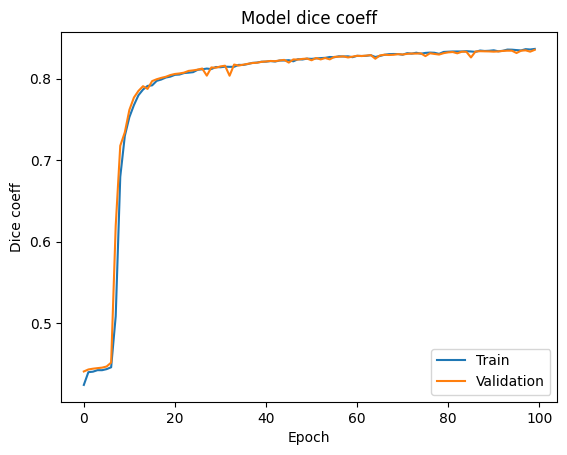

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# 9. Predicting the results for test data

In [ ]:
model.load_weights('3d_image_segmentation.h5')
prediction = model.predict(X_test)

10/10 [==============================] - 0s 13ms/step


# 10. Output Visualisation

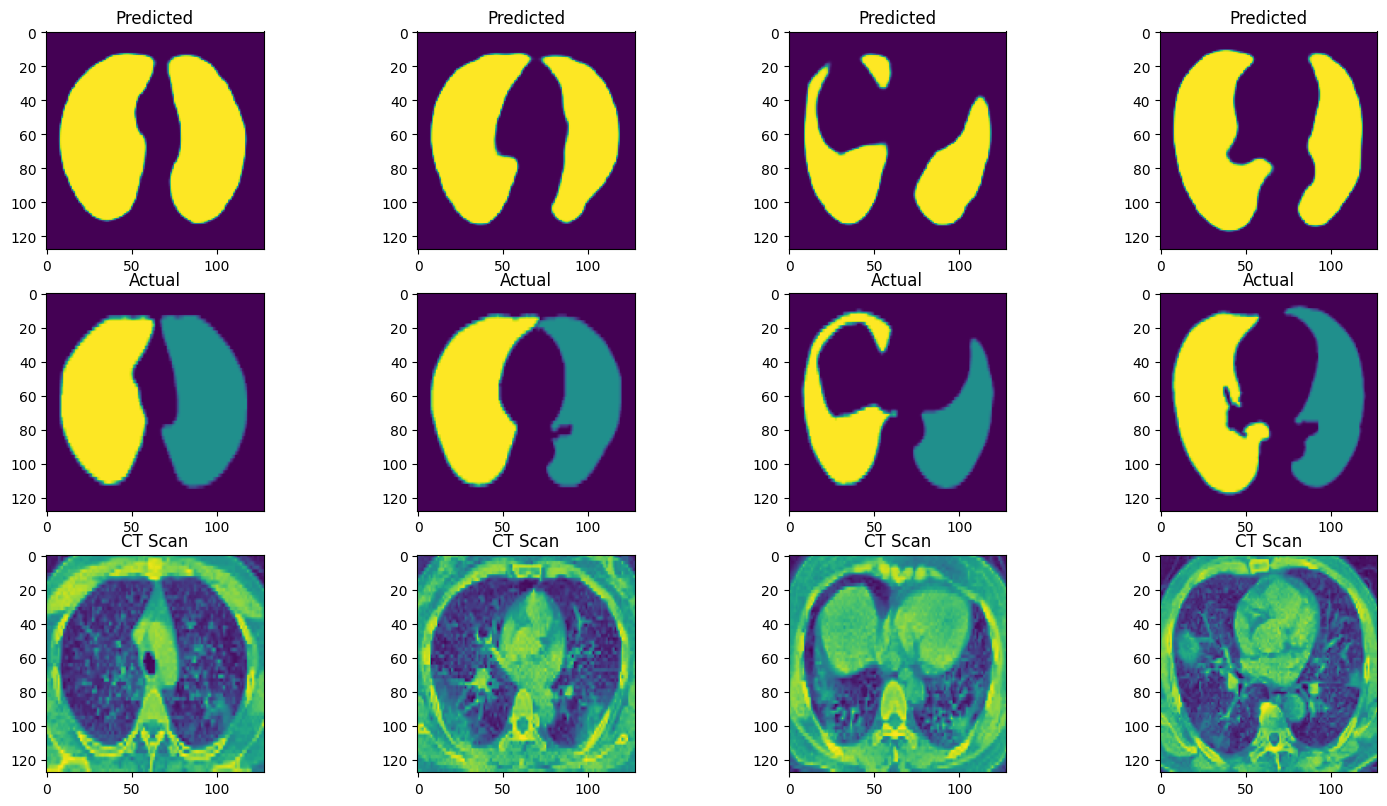

In [ ]:
import random
fig, axes = plt.subplots(3, 4, figsize=(15,8))
fig.tight_layout()
for i in range(4):
    c = random.randint(0,prediction.shape[0]-1)
    axes[0,i].imshow(np.squeeze(prediction[c]))
    axes[0,i].set_title('Predicted')
    axes[1,i].imshow(np.squeeze(Y_test[c]))
    axes[1,i].set_title('Actual')
    axes[2,i].imshow(np.squeeze(X_test[c]))
    axes[2,i].set_title('CT Scan')

# **STEP 4: Infection Segmentation**

# 1. Loading data

In [ ]:
infile = open('Processed_Data.cp','rb')
data_dict = pickle.load(infile)
all_cts = data_dict['cts']
all_lungs = data_dict['lungs']
all_inf = data_dict['infects']
infile.close()

In [ ]:
print(all_cts.shape)
print(all_lungs.shape)
print(all_inf.shape)

(1564, 128, 128, 1)
(1564, 128, 128, 1)
(1564, 128, 128, 1)


In [ ]:
from sklearn.utils import shuffle
all_cts, all_lungs, all_inf = shuffle(all_cts, all_lungs, all_inf)

In [ ]:
all_cts = (all_cts - all_cts.min())/(all_cts.max()-all_cts.min())
all_lungs = (all_lungs - all_lungs.min())/(all_lungs.max()-all_lungs.min())
all_inf = (all_inf - all_inf.min())/(all_inf.max()-all_inf.min())

print("{} {}".format(all_cts.min(), all_cts.max()))
print("{} {}".format(all_lungs.min(), all_lungs.max()))
print("{} {}".format(all_inf.min(), all_inf.max()))

0.0 1.0
0.0 1.0
0.0 1.0


# 2. Splitting data into training and validation sets

In [ ]:
train_size = int(0.65*all_cts.shape[0])
X_train, yl_train, yi_train = (all_cts[:train_size]/255, all_lungs[:train_size], all_inf[:train_size])
X_valid, yl_valid, yi_valid = (all_cts[train_size:int(0.8*all_cts.shape[0])]/255, 
                               all_lungs[train_size:int(0.8*all_cts.shape[0])], 
                               all_inf[train_size:int(0.8*all_cts.shape[0])])
test_size = int(0.8*all_cts.shape[0])
X_test, yl_test, yi_test = (all_cts[test_size:]/255, all_lungs[test_size:], all_inf[test_size:])
print(X_train.shape, yl_train.shape, yi_train.shape)
print(X_valid.shape, yl_valid.shape, yi_valid.shape)
print(X_test.shape, yl_test.shape, yi_test.shape)

(1016, 128, 128, 1) (1016, 128, 128, 1) (1016, 128, 128, 1)
(235, 128, 128, 1) (235, 128, 128, 1) (235, 128, 128, 1)
(313, 128, 128, 1) (313, 128, 128, 1) (313, 128, 128, 1)


# 3. Define evaluation metrics
We will use dice coefficient as a metric for infection segmentation. Dice coefficient is (2TP/2TP+FN+FP) where TP, FN and FP correspond to true positive, false negative and false positive.

In [ ]:
def dice(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_loss(y_true, y_pred):
  loss = 1 - dice(y_true, y_pred)
  return loss

def bce_dice_loss(y_true, y_pred):
  loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
  return loss

class CosineAnnealingLearningRateSchedule(callbacks.Callback):
  def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
    self.epochs = n_epochs
    self.cycles = n_cycles
    self.lr_max = lrate_max
    self.lrates = list()

  def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
    epochs_per_cycle = np.floor(n_epochs/n_cycles)
    cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    return lrate_max/2 * (np.cos(cos_inner) + 1)

  def on_epoch_begin(self, epoch, logs=None):
    lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
    K.set_value(self.model.optimizer.lr, lr)
    self.lrates.append(lr)

# 4. CNN

In [ ]:
def block1 (input_shape, filtersize, poolsz=(2,2)) :
    x = Conv2D(filtersize, (3,3), activation='relu', padding='same', kernel_initializer="he_normal") (input_shape)
    x = Conv2D(filtersize, (3,3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
    x_inter = BatchNormalization()(x)
    x = MaxPooling2D(poolsz) (x_inter) 
    x = Dropout(0.2)(x) 
    return x, x_inter

def block2 (input_shape, filtersize) :
    x = BatchNormalization() (input_shape)
    x = Conv2D(filtersize, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x)
    x = Conv2D(filtersize, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (x) 
    return x

In [ ]:
def infection_segmentation(input_shape) :
  x_input = Input(input_shape)

  x, Xa = block1(x_input, 32)
  x, Xb = block1(x, 64)
  x, _ = block1(x, 128, poolsz=(1,1))
  x, _ = block1(x, 256, poolsz=(1,1))
  x = block2(x, 256)

  x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x)
  x = block2(x, 128)

  x = Conv2DTranspose(64, (2, 2), padding='same') (x)
  x = concatenate([x, Xb])
  x = block2(x, 64)

  x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x)
  x = concatenate([x, Xa], axis=3)
  x = block2(x, 32)

  infection_segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='infect_output') (x)

  model = Model(inputs=x_input, outputs=infection_segmentation, name='infect_model')
    
  return model

strategy = tf.distribute.MirroredStrategy()
print('Devices {}'.format(strategy.num_replicas_in_sync))
with strategy.scope() :
    infection_segmentation = infection_segmentation(all_cts.shape[1:])

infection_segmentation.summary()

Devices 1
Model: "infect_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_16[0][0]']              
                                )                                            

In [ ]:
epochs = 100
lrmax = 5e-5
n_cycles = epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(epochs, n_cycles, lrmax)
checkpoint_fpath = "infection_segmentation_weights.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_dice', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

batch_size = 8
optim = optimizers.Adam(lr=5e-5, beta_1=0.9, beta_2=0.99)
with strategy.scope() :
    infection_segmentation.compile(optimizer=optim, loss=bce_dice_loss, metrics=[dice])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# 5. Train Model

In [ ]:
infection_segmentation_res = infection_segmentation.fit(x = X_train, 
                            y = yi_train,
                            batch_size = batch_size, 
                            epochs = epochs,
                            verbose = 1,
                            validation_data = (X_valid, yi_valid),
                            callbacks = [cts_checkpoint_cb, lr_cb])

Epoch 1/100
127/127 [==============================] - ETA: 0s - loss: 0.4936 - dice: 0.1838
Epoch 1: val_dice improved from -inf to 0.00515, saving model to infection_segmentation_weights.hdf5
127/127 [==============================] - 21s 113ms/step - loss: 0.4936 - dice: 0.1838 - val_loss: 0.6454 - val_dice: 0.0052
Epoch 2/100
127/127 [==============================] - ETA: 0s - loss: 0.3223 - dice: 0.4640
Epoch 2: val_dice did not improve from 0.00515
127/127 [==============================] - 12s 98ms/step - loss: 0.3223 - dice: 0.4640 - val_loss: 0.6844 - val_dice: 0.0046
Epoch 3/100
127/127 [==============================] - ETA: 0s - loss: 0.2863 - dice: 0.5337
Epoch 3: val_dice did not improve from 0.00515
127/127 [==============================] - 12s 92ms/step - loss: 0.2863 - dice: 0.5337 - val_loss: 0.6832 - val_dice: 0.0050
Epoch 4/100
127/127 [==============================] - ETA: 0s - loss: 0.2655 - dice: 0.5706
Epoch 4: val_dice improved from 0.00515 to 0.00560, savin

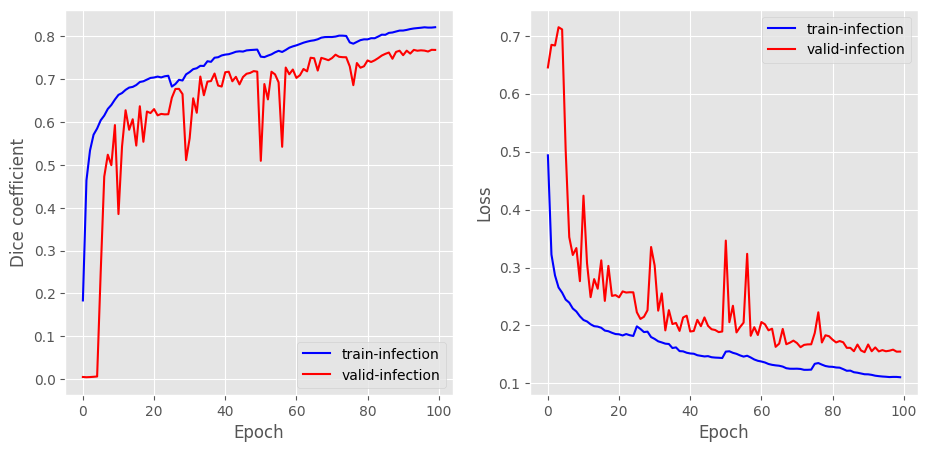

In [ ]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(infection_segmentation_res.history['dice'], color='b', label='train-infection')
axes[0].plot(infection_segmentation_res.history['val_dice'], color='r', label='valid-infection')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(infection_segmentation_res.history['loss'], color='b', label='train-infection')
axes[1].plot(infection_segmentation_res.history['val_loss'], color='r', label='valid-infection')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend();

# 6. Saving loads

In [ ]:
infection_segmentation.load_weights('infection_segmentation_weights.hdf5')
prediction = infection_segmentation.predict(X_test)

# 7. Testing

In [ ]:
def plot_lung_seg(all_cts, all_lungs, all_inf, pred_infs, axes) :

    axes[0].imshow(all_cts[:,:,0], cmap='bone')
    axes[0].set_title('CT image'); plt.grid(None)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    
    axes[1].imshow(all_lungs[:,:,0], cmap='bone')
    axes[1].imshow(all_inf[:,:,0], alpha=0.5, cmap='Reds')
    axes[1].set_title('Infection mask'); plt.grid(None)
    axes[1].set_xticks([]); axes[1].set_yticks([])

    axes[2].imshow(all_lungs[:,:,0], cmap='bone')
    axes[2].imshow(pred_infs[:,:,0], alpha=0.5, cmap='Reds')
    axes[2].set_title('Pred. Infection mask'); plt.grid(None)
    axes[2].set_xticks([]); axes[2].set_yticks([])

In [ ]:
import random
indices = random.choices(range(len(X_test)), k=5)
fig, axes = plt.subplots(3, 5, figsize=(15,9))

for ii, idx in enumerate(indices) :
    plot_lung_seg(X_test[idx], yl_test[idx], yi_test[idx], prediction[idx], list(axes[:,ii]))